# best-transformer-representations
https://uku28motab.feishu.cn/docs/doccnUDbEhudHm2V440lcY87B1c

In [1]:
# I导入库文件

import os
import numpy as np
import pandas as pd
import random

from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, logging

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, SequentialSampler, RandomSampler, DataLoader

from tqdm.notebook import tqdm

import gc; gc.enable()
from IPython.display import clear_output

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
logging.set_verbosity_error()

In [2]:
# 定义参数

INPUT_DIR = '../input/commonlitreadabilityprize'
MODEL_NAME = 'roberta-large'
# roberta large参数
HIDDEN_SIZE = 1024
NUM_HIDDEN_LAYERS = 24

LAYER_START = 4   # 用于WeightedLayerPoolingModel

HIDDEN_DIM_FC = 128    # 用于AttentionPooling

MAX_LENGTH = 300
LR = 2e-5
EPS = 1e-8

SEED = 42

NUM_FOLDS = 5
SEEDS = [113, 71, 17, 43, 37]

EPOCHS = 5
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 32

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Utilities

# 实用程序类和函数
# 分层交叉验证
class ContinuousStratifiedKFold(StratifiedKFold):
    def split(selfself, x, y, groups=None):
        num_bins = int(np.floor(1 + np.log2(len(y))))
        bins = pd.cut(y, bins=num_bins, labels=False)
        return super().split(x, bins, groups)
# 随机种子   
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
# 数据读取    
def get_data_loaders(data, fold):
    # 获取训练和验证数据
    x_train = data.loc[data.fold != fold, 'excerpt'].tolist()
    y_train = data.loc[data.fold != fold, 'target'].values
    x_val = data.loc[data.fold == fold, 'excerpt'].tolist()
    y_val = data.loc[data.fold == fold, 'target'].values
    # 读取预训练分词器
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    # 训练编码
    encoded_train = tokenizer.batch_encode_plus(
        x_train, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        padding='max_length', 
        truncation=True,
        max_length=MAX_LENGTH, 
        return_tensors='pt'
    )
    # 验证编码
    encoded_val = tokenizer.batch_encode_plus(
        x_val, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        padding='max_length', 
        truncation=True,
        max_length=MAX_LENGTH, 
        return_tensors='pt'
    )
    # 训练数据处理
    dataset_train = TensorDataset(
        encoded_train['input_ids'],
        encoded_train['attention_mask'],
        torch.tensor(y_train)
    )
    # 验证数据处理
    dataset_val = TensorDataset(
        encoded_val['input_ids'],
        encoded_val['attention_mask'],
        torch.tensor(y_val)
    )
    # 导入训练数据到模型中
    dataloader_train = DataLoader(
        dataset_train,
        sampler = RandomSampler(dataset_train),
        batch_size=TRAIN_BATCH_SIZE
    )
    # 导入验证数据到模型中
    dataloader_val = DataLoader(
        dataset_val,
        sampler = SequentialSampler(dataset_val),
        batch_size=VAL_BATCH_SIZE
    )

    return dataloader_train, dataloader_val

<h2>Model definitions</h2>

In [4]:
# 各种模型定义

class PoolerModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        config.update({'num_labels':1})
        self.model = AutoModel.from_pretrained(model_name, config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        pooler_output = outputs[1]
        logits = self.linear(pooler_output)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        

class LastLayerCLSModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        last_hidden_state = outputs[0]
        cls_embeddings = last_hidden_state[:,0]
        logits = self.linear(cls_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        

class MeanPoolingModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        last_hidden_state = outputs[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        logits = self.linear(mean_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        

class MaxPoolingModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        last_hidden_state = outputs[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        last_hidden_state[input_mask_expanded == 0] = -1e9   # large negative value
        max_embeddings, _ = torch.max(last_hidden_state, 1)
        logits = self.linear(max_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
        
class SecondToLastLayerCLSModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        config.update({'output_hidden_states':True})
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        all_hidden_states = torch.stack(outputs[2])
        second_to_last_layer = 23
        cls_embeddings = all_hidden_states[second_to_last_layer,:,0]
        logits = self.linear(cls_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
class ConcatenateLastFourModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        config.update({'output_hidden_states':True})
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(4*HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        all_hidden_states = torch.stack(outputs[2])
        concatenate_pooling = torch.cat(
            (all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]), -1
        )
        concatenate_pooling = concatenate_pooling[:,0]
        logits = self.linear(concatenate_pooling)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
        
class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, all_hidden_states):
        all_layer_embedding = all_hidden_states[self.layer_start:, :, :, :]
        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
        return weighted_average
    
class WeightedLayerPoolingModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        config.update({'output_hidden_states':True})
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.pooling = WeightedLayerPooling(NUM_HIDDEN_LAYERS, 
                                      layer_start=LAYER_START,
                                      layer_weights=None)
        self.layer_norm = nn.LayerNorm(HIDDEN_SIZE)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        all_hidden_states = torch.stack(outputs[2])
        
        weighted_pooling_embeddings = self.pooling(all_hidden_states)
        weighted_pooling_embeddings = weighted_pooling_embeddings[:,0]
        
        norm_embeddings = self.layer_norm(weighted_pooling_embeddings)
        logits = self.linear(norm_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        
class AttentionPooling(nn.Module):
    def __init__(self, num_layers, hidden_size, hiddendim_fc):
        super(AttentionPooling, self).__init__()
        self.num_hidden_layers = num_layers
        self.hidden_size = hidden_size
        self.hiddendim_fc = hiddendim_fc
        self.dropout = nn.Dropout(0.1)

        q_t = np.random.normal(loc=0.0, scale=0.1, size=(1, self.hidden_size))
        self.q = nn.Parameter(torch.from_numpy(q_t)).float().to(DEVICE)
        w_ht = np.random.normal(loc=0.0, scale=0.1, size=(self.hidden_size, self.hiddendim_fc))
        self.w_h = nn.Parameter(torch.from_numpy(w_ht)).float().to(DEVICE)

    def forward(self, all_hidden_states):
        hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze()
                                     for layer_i in range(1, self.num_hidden_layers+1)], dim=-1)
        hidden_states = hidden_states.view(-1, self.num_hidden_layers, self.hidden_size)
        out = self.attention(hidden_states)
        out = self.dropout(out)
        return out

    def attention(self, h):
        v = torch.matmul(self.q, h.transpose(-2, -1)).squeeze(1)
        v = F.softmax(v, -1)
        v_temp = torch.matmul(v.unsqueeze(1), h).transpose(-2, -1)
        v = torch.matmul(self.w_h.transpose(1, 0), v_temp).squeeze(2)
        return v

class AttentionPoolingModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        config.update({'output_hidden_states':True})
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.pooler = AttentionPooling(NUM_HIDDEN_LAYERS, HIDDEN_SIZE, HIDDEN_DIM_FC)
        
        self.linear = nn.Linear(HIDDEN_DIM_FC, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        all_hidden_states = torch.stack(outputs[2])
        
        attention_pooling_embeddings = self.pooler(all_hidden_states)
        
        logits = self.linear(attention_pooling_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
        

<h2>Read data and create folds</h2>

For the results to be reproducible, I create the same folds I'm using in the competition.

In [5]:
# 读取数据
data = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))

# 分层交叉验证
kf = ContinuousStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for f, (t_, v_) in enumerate(kf.split(data, data.target)):
    data.loc[v_, 'fold'] = f
data['fold'] = data['fold'].astype(int)


<h2>Training and evaluation</h2>

In [6]:
# 验证函数 
def evaluate(model, val_dataloader):

    model.eval()
    
    loss_val_total = 0
    
    for batch in val_dataloader:
        
        batch = tuple(b.to(DEVICE) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            loss = model(**inputs)
            
        loss_val_total += loss.item()

    loss_val_avg = loss_val_total/len(val_dataloader) 
            
    return loss_val_avg

# 训练函数
def train(model, train_dataloader, val_dataloader):
    
    optimizer = AdamW(model.parameters(), lr = LR, eps = EPS)

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
                                                num_training_steps=len(train_dataloader) * EPOCHS)
    best_val_loss = 1
    model.train()
                                                
    for epoch in range(EPOCHS):
    
        loss_train_total = 0
        for batch in tqdm(train_dataloader):
    
            model.zero_grad()
            batch = tuple(b.to(DEVICE) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }
        
            loss = model(**inputs)
            loss_train_total += loss.item()
        
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        loss_train_avg = loss_train_total / len(train_dataloader)
        loss_val_avg = evaluate(model, val_dataloader)
        print(f'epoch:{epoch+1}/{EPOCHS} train loss={loss_train_avg}  val loss={loss_val_avg}')
   
        if loss_val_avg < best_val_loss:
            best_val_loss = loss_val_avg
            
    return best_val_loss

The process takes more than eight hours with Kaggle kernels, so I've included a termination condition for MAX_RUNS=2 runs (instead of the 5 seeds x 5 folds = 25 runs). Just remove it in both loops to run the full experiment.

In [7]:
# Main loop

losses = []

MAX_RUNS = 2
runs = 0   # 控制终止条件的变量

for i, seed in enumerate(SEEDS):
       
    # 结束条件
    if runs == MAX_RUNS:
        print(f'{runs} runs termination condition reached.')
        break    
    
    print(f'********* seed({i}) = {seed} ***********')
    
    for fold in range(NUM_FOLDS):
        print(f'*** fold = {fold} ***')
        seed_everything(seed)
        train_dataloader, val_dataloader = get_data_loaders(data, fold)
        
        # 修改目前在用的模型
        model = PoolerModel(MODEL_NAME)
        model.to(DEVICE)
        
        loss = train(model, train_dataloader, val_dataloader)
        losses.append(loss)
        
        del model
        gc.collect()
        
        # 终止条件设置
        runs += 1
        if runs == MAX_RUNS:
            break
    

********* seed(0) = 113 ***********
*** fold = 0 ***


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

  0%|          | 0/284 [00:00<?, ?it/s]

epoch:1/5 train loss=0.501669784142098  val loss=1.0456004805035062


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:2/5 train loss=0.2207454034901211  val loss=0.2563667479488585


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:3/5 train loss=0.0725503308226315  val loss=0.26245757192373276


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:4/5 train loss=0.020748161544783934  val loss=0.25851768338017994


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:5/5 train loss=0.005722257886844372  val loss=0.25742922971645993
*** fold = 1 ***


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:1/5 train loss=0.4344233691193898  val loss=0.3352832156750891


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:2/5 train loss=0.17613861505860384  val loss=0.27765414284335244


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:3/5 train loss=0.05939924555853612  val loss=0.2808803874585364


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:4/5 train loss=0.02080610659117745  val loss=0.2770214652021726


  0%|          | 0/284 [00:00<?, ?it/s]

epoch:5/5 train loss=0.006143457030190457  val loss=0.2687056561311086
2 runs termination condition reached.


<h2>Results</h2>

In [8]:
# 保存损失(每个模型一个列)

# 阅读之前模型的结果
try:
    results = pd.read_csv('experiment-1.csv')
except:
    results = pd.DataFrame(data=None)
    
# 用代表模型的名称更改损失列表: 
results['pooler'] = losses
results.to_csv('experiment-1.csv', index=False)

<AxesSubplot:>

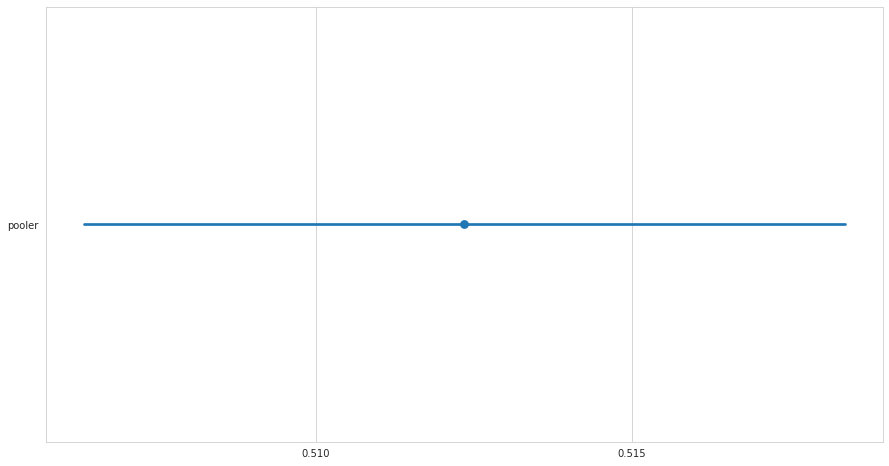

In [9]:
# 绘制RMSE均值的95%置信区间

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xticks(np.arange(0.45, 0.54, step=0.005))
ax.set_axis_on()
sns.pointplot(data=np.sqrt(results), ci=95, orient='h', ax=ax)